In [187]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow .keras.applications import resnet50
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from functools import partial
import pickle
import os
import recmetrics
from typing import List

# Getting the Data

In [146]:
# Create a list of all the images in our dataset
dataset_path = '../tiny_imagenet/train'
image_path = '{dataset_path}/{label}/{name}'
image_path_list = []
label_image_names = []

for label_name in os.listdir(dataset_path):
    image_names = []
    for filename in os.listdir(os.path.join(dataset_path, label_name)):
        if filename == '.DS_Store':
            pass
        image_path_list.append(image_path.format(dataset_path=dataset_path, label=label_name, name=filename))
        image_names.append(filename)
    label_image_names.append(image_names)
        
print(image_path_list)


['../tiny_imagenet/train/n03394916/ILSVRC2012_val_00046669.JPEG', '../tiny_imagenet/train/n03394916/n03394916_58454.JPEG', '../tiny_imagenet/train/n03394916/n03394916_32588.JPEG', '../tiny_imagenet/train/n03394916/n03394916_33663.JPEG', '../tiny_imagenet/train/n03394916/n03394916_27948.JPEG', '../tiny_imagenet/train/n03394916/n03394916_38644.JPEG', '../tiny_imagenet/train/n03394916/n03394916_35076.JPEG', '../tiny_imagenet/train/n03394916/n03394916_38214.JPEG', '../tiny_imagenet/train/n03394916/n03394916_23008.JPEG', '../tiny_imagenet/train/n03394916/n03394916_33008.JPEG', '../tiny_imagenet/train/n03394916/n03394916_7606.JPEG', '../tiny_imagenet/train/n03394916/n03394916_35133.JPEG', '../tiny_imagenet/train/n03394916/n03394916_28428.JPEG', '../tiny_imagenet/train/n03394916/n03394916_53473.JPEG', '../tiny_imagenet/train/n03394916/n03394916_28994.JPEG', '../tiny_imagenet/train/n03394916/n03394916_44089.JPEG', '../tiny_imagenet/train/n03394916/n03394916_11495.JPEG', '../tiny_imagenet/train

# Create feauture representation for the data

In [147]:
# Example
random_image_path = '../tiny_imagenet/train/n01440764/ILSVRC2012_val_00011233.JPEG'
toy_image = load_img(random_image_path, target_size=(256, 256))
toy_image = img_to_array(toy_image)
toy_image = np.expand_dims(toy_image, axis=0)
preprocess_toy_image = resnet50.preprocess_input(toy_image)
toy_image.shape

(1, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


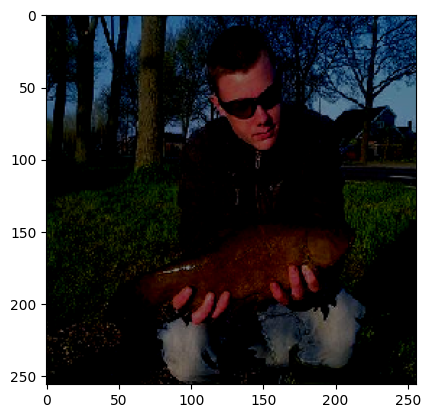

In [148]:
plt.imshow(toy_image[0,...]/255)

In [149]:
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)

In [151]:
image_feature = []
for image_path in tqdm(image_path_list):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preprocess_image = resnet50.preprocess_input(image)
    feature = model.predict(preprocess_image, verbose=0).flatten()
    image_feature.append(feature)

100%|██████████| 9469/9469 [11:02<00:00, 14.30it/s]


In [152]:
from sklearn.metrics.pairwise import cosine_similarity

In [153]:
random_testing_image_path = '../tiny_imagenet/val/n03417042/ILSVRC2012_val_00033842.JPEG'
# getting the feauture for the testing image
test_image = load_img(random_testing_image_path, target_size=(224, 224))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
preprocess_test_image = resnet50.preprocess_input(test_image)
feature = model.predict(preprocess_test_image).flatten()




1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


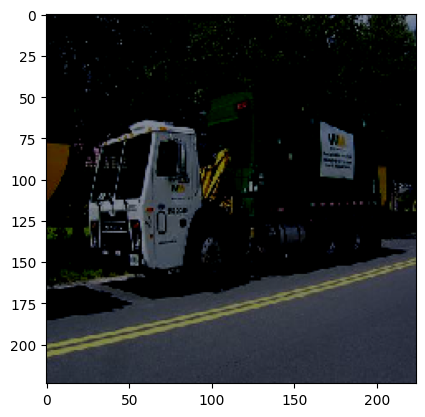

In [154]:
plt.imshow(test_image[0,...]/255)

In [155]:
feature.shape

(2048,)

In [159]:
similarity = []
for feauture_y in image_feature:
    similarity.append(cosine_similarity(feature.reshape(1, -1), feauture_y.reshape(1, -1))[0][0])
index_pos = sorted(list(enumerate(similarity)), reverse=True, key=lambda x: x[1])[0][0]

In [160]:
index_pos

1790

In [161]:
similar_image_path = image_path_list[index_pos]
similar_image = load_img(similar_image_path, target_size=(256, 256))
similar_image = img_to_array(similar_image)

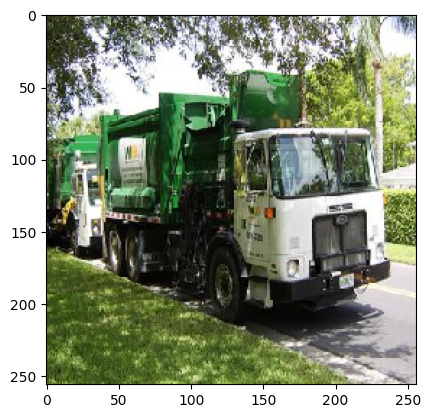

In [162]:
plt.imshow(similar_image/255)

# Evaluation your model

In [163]:
test_path = '../tiny_imagenet/val'
image_path = '{dataset_path}/{label}/{name}'
test_path_list = []
label_index = []
for index, label_name in enumerate(os.listdir(test_path)):
    for filename in os.listdir(os.path.join(test_path, label_name)):
        if filename == '.DS_Store':
            pass
        test_path_list.append(image_path.format(dataset_path=test_path, label=label_name, name=filename))
        label_index.append(index)
        

In [164]:
## Creating features for the test data
test_feature = []
for i, image_path in tqdm(enumerate(test_path_list)):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preprocess_image = resnet50.preprocess_input(image)
    feature = model.predict(preprocess_image, verbose=0).flatten()
    test_feature.append(feature)

3925it [04:34, 14.32it/s]


In [179]:
k = 20
predictions = []
labels = []
for index, test in enumerate(test_feature):
    similarity = []
    for feauture_y in image_feature:
        similarity.append(cosine_similarity(feature.reshape(1, -1), feauture_y.reshape(1, -1))[0][0:k])
    index_pos = sorted(list(enumerate(similarity)), reverse=True, key=lambda x: x[1])[0:20]
    index_list = [x[0] for x in index_pos]
    prediction_name = [image_path_list[i].split('/')[-1] for i in  index_list]
    predictions.append(prediction_name)
    labels.append(label_image_names[label_index[index]])

KeyboardInterrupt: 

In [205]:
labels[0] == labels[394]

False

In [192]:
mapk(actual=predictions, predicted=predictions, k=20)

1.0

In [188]:
def _precision(predicted, actual):
    prec = [value for value in predicted if value in actual]
    prec = float(len(prec)) / float(len(predicted))
    return prec

def _apk(actual: list, predicted: list, k=10) -> float:
    """
    Computes the average precision at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : float
        The average precision at k.
    """
    if not predicted or not actual:
        return 0.0
    
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    true_positives = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            max_ix = min(i + 1, len(predicted))
            score += _precision(predicted[:max_ix], actual)
            true_positives += 1
    
    if score == 0.0:
        return 0.0
    
    return score / true_positives

def mapk(actual: List[list], predicted: List[list], k: int=10) -> float:
    """
    Computes the mean average precision at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: float
            The mean average precision at k (map@k)
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")
    
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])

